# This notebook configures a CFM run for a single site in Greenland, runs the CFM, and processes/plots the outputs.

### It should run if you put it in the CFM_main directory.

In [1]:
### Import necessary python packages and CFM code.
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
import datetime
import time
import json
import shutil
import xarray as xr
import copy

SPY = 365.25*24*3600

try:
    sys.path.append('/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main')
except:
    pass

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [2]:
### Set plot parameters (seaborn, matplotlib)
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

In [3]:
### These are bunch of lat/lon pairs for sites in Greenland
### (don't need it for now)
def getLL(site):
    if site == 'Summit':
        lat_int = 72.57972 #summit
        lon_int = -38.50454 
    elif site == 'DYE2':
        lat_int = 66.4806 #this is DYE2
        lon_int = -46.2831
    elif site == 'KANU':
        lat_int = 67.000383
        lon_int = -47.02615
    elif site == 'EKT':
        lat_int = 66.9854
        lon_int = -44.39465
    elif site == 'NASASE':
        lat_int = 66.47768
        lon_int = -42.49635
    elif site == 'SADDLE':
        lat_int = 65.9994
        lon_int = -44.50248
    elif site == 'CRAWFORD':
        lat_int = 69.87615
        lon_int = -47.03112
    elif site == 'EGRIP':
        lat_int = 75.62556
        lon_int = -35.
    elif site == 'AQUIFER':
        lat_int = 66.362
        lon_int = -39.312
    elif site == 'other': # use this one to make a site for any random lat lon pair
        lat_int = 78.0
        lon_int = -71.875
    elif site == 'SD1':
        lat_int = 63.1490
        lon_int = -44.8170
    elif site == 'FA13':
        lat_int = 66.1812
        lon_int = -39.0435
    return lat_int, lon_int

### You will need to change this cell to fit the lat/lon values and the filename prefix that you want

In [4]:
lat_int = 72.5 # latitude of interest
lon_int = -38.75 #longitude
# data_source = 'CFM_smetinput'
data_source = 'MERRA2_CLIM_df'

### In general, the lat/lon on the MERRA2 grid will not be the same at the 'int' values you put in - the function above 
### finds the MERRA2 grid point closest to the point you entered, and saves it as 'lat_val' and 'lon_val'
### but for now we can just set them equal, and load the .pkl for that point.

lat_val = lat_int
lon_val = lon_int

# df_daily = pd.read_pickle(f'{data_source}_{lat_val}_{lon_val}.pkl')
try:
    df_daily = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main/MERRA2_CLIM_df_{lat_val}_{lon_val}.pkl')
except:
    df_daily = pd.read_pickle(f'/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main/IDS/pickle/MERRA2_CLIM_df_{lat_int}_{lon_int}.pkl')

t_adjust = 3 #adjust the modeled temperature by adding 1.5 degrees Celsius
df_daily_adjusted = df_daily.copy()
df_daily_adjusted['TS'] = df_daily_adjusted['TS'] + t_adjust

In [5]:
### I have Greenland climate data from MERRA-2 stored in a .zarr file, but that is big-ish (3.4GB)
### so in general climate data will be imported from something like that

### This function creates the dataframe for a given lat/lon pair with the RCM (MERRA-2) data

# def df_fromZarr(lat_int,lon_int):
#     fn = 'M2_GrIS_daily_melt.zarr'
#     dsZ = xr.open_dataset(fn,engine='zarr')
#     lat_ll = dsZ.lat.data
#     lon_ll = dsZ.lon.data
#     ii, lat_val = min(enumerate(lat_ll), key=lambda x: abs(x[1]-lat_int))
#     jj, lon_val = min(enumerate(lon_ll), key=lambda x: abs(x[1]-lon_int))
#     TSx = dsZ.isel(lat=[ii],lon=[jj]).TS.values.flatten()
#     PTCx = dsZ.isel(lat=[ii],lon=[jj]).PRECTOTCORR.values.flatten()
#     SNOx = dsZ.isel(lat=[ii],lon=[jj]).PRECSNO.values.flatten()
#     RAINx = PTCx - SNOx
#     EVx = dsZ.isel(lat=[ii],lon=[jj]).EVAP.values.flatten()
#     SMELTx = dsZ.isel(lat=[ii],lon=[jj]).SMELT.values.flatten()
#     timex = dsZ.time.data
#     df_daily = pd.DataFrame({'TS':TSx,'BDOT':SNOx,'RAIN':RAINx,'SMELT':SMELTx,'SUBLIM':EVx},index=timex)
#     dsZ.close()
#     return ii,jj,lat_val,lon_val,df_daily

In [6]:
### The input dataframe has 4 columns: TS (surface, or skin, temperature); BDOT (snow accumulation); RAIN; SMELT (snowmelt)
### The units for the mass fluxes (I think!) are kg/m^2/day.
df_daily.head()

,TS,EVAP,SMELT,PRECTOT,PRECSNO
time,,,,,
1980-01-01,236.864014,-0.023392,0.0,0.623080,0.623080
1980-01-02,231.452515,-0.026929,0.0,0.245588,0.245588
1980-01-03,238.441223,-0.090302,0.0,0.814976,0.814976
1980-01-04,235.648422,-0.039976,0.0,0.432885,0.432885
1980-01-05,237.515213,-0.093008,0.0,0.773286,0.773286


<AxesSubplot:xlabel='time'>

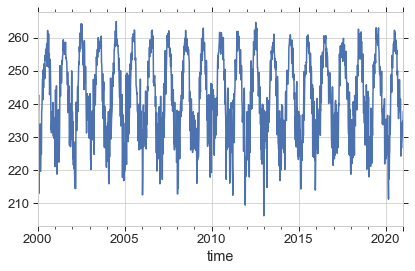

In [7]:
# You can do things like resample, subsample, and plot the input data
f1,a1=plt.subplots()
((df_daily.TS.resample('5d').mean())['2000':]).plot(ax=a1)

In [8]:
# or find the warmest temperature 
df_daily.TS.max()

268.9266052246094

In [9]:
### This function contains all of the CFM configuration options. You can change them, and the configuration gets stored as a .json file.
### The values here are more or less the defaults.

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput/test",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": true,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": true,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": false,
    "grid_output_res": 0.25,
    "isoDiff": false,
    "iso": "NoDiffusion",
    "isoOptions":["18","D","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","meltoutputs","Dcon"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 30.0,
    "grid2bottom": 35.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True
    }

    return c

In [10]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def decyeartodatetime(din):
    start = din
    rem, year = np.modf(din)
    base = datetime.datetime(int(year), 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result2 = result.replace(second=0, microsecond=0)
    return result2

## The following is used for manually altering the variables for each model run

In [11]:
# # This cell runs the CFM

# tnow = time.time()
# runid=-9999

# ### The CFM takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
# ### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
# ### containing the vectors that the CFM needs to run.
# ### the function also returns some other variables that will be used to configure the CFM run.
# timeres = '5D' # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc
# Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(df_daily.copy(),timeres=timeres,Tinterp='mean',spin_date_st = 1980.0, spin_date_end = 1995.0,desired_depth=100)

# #######
# ### Prepare config .json (which is a dictionary called c within this python script) ###
# ### edit as you wish here (the makejson function above just has defaults, you can change there as well)
# c = makejson()
# c['physRho'] = 'GSFC2020' # try with 'GSFC2020' and 'KuipersMunneke2015'
# c['runID'] = runid
# c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
# c["doublegrid"] = True
# c['nodestocombine'] = 6 
# c['multnodestocombine'] = 12
# c['MELT'] = True #you can set to false to make things run a lot faster if don't care about results
# c["stpsPerYear"] = StpsPerYr
# c["stpsPerYearSpin"] = StpsPerYr
# c["grid1bottom"] = 20
# c["grid2bottom"] = 25
# # c["grid1bottom"] = depth_S1
# # c["grid2bottom"] = depth_S2
# c["HbaseSpin"] = 3000 - grid_bottom
# c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
# c["rhos0"] = 325  # e.g here you could change the surface density
# c['liquid'] = 'bucket'
# c['InputFileNamedudx'] = None
# #######

# ### Specify where results should go ###
# reDir = 'CFMoutputs/CFMresults_{}_{}_{}_{}'.format(lat_val,lon_val,c['physRho'],c["rhos0"])
# c['resultsFolder'] = reDir
# ##########

# configName = 'CFMconfig_{}_{}_{}.json'.format(lat_val,lon_val,c['nodestocombine'])
# if os.path.exists(os.path.join(c['resultsFolder'],configName)):
#     CFMconfig = os.path.join(c['resultsFolder'],configName)
#     shutil.move(CFMconfig, os.getcwd())
# # else:
# CFMconfig = configName
# with open(CFMconfig,'w') as fp:
#     fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

# firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
# firn.time_evolve()
# telap = (time.time()-tnow)/60
# print('main done, {} minutes'.format(telap))

# shutil.move(configName,reDir)

## The following loops through the Physics Schemes and model run choices

In [12]:
fns = ['KuipersMunneke2015','GSFC2020'] # sets the filenames equal to the 2 physics schemes 
# fns = ['HLdynamic', 'Li2011']
# fns = ['Morris2014', 'Crocus']
# rvs = [325,350] # surface density (rho) values
rvs = [315,325] # surface density (rho) values
for physics in fns:
    for rv in rvs:
        tnow = time.time()
        runid=-9999

        ### The CFM takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
        ### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
        ### containing the vectors that the CFM needs to run.
        ### the function also returns some other variables that will be used to configure the CFM run.
        timeres = '5D' # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc
        TADJUST = False       
        if TADJUST ==False:        
            Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(df_daily.copy(),timeres=timeres,Tinterp='mean',spin_date_st = 1980.0, spin_date_end = 2020.0,desired_depth=100)
        else:
            t_adjust= 3
            Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(df_daily_adjusted.copy(),timeres=timeres,Tinterp='mean',spin_date_st = 1980.0, spin_date_end = 2020.0,desired_depth=100)
        print('average T:', Cd['TSKIN'].mean())
        
        #######
        ### Prepare config .json (which is a dictionary called c within this python script) ###
        ### edit as you wish here (the makejson function above just has defaults, you can change there as well)
        c = makejson()
        c['physRho'] = physics # setting the physics scheme to 'KuipersMunneke2015' and 'GSFC2020' within fns
        c['runID'] = runid
        c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
        c["doublegrid"] = True
        c['nodestocombine'] = 6 
        c['multnodestocombine'] = 12
        c['MELT'] = True #you can set to false to make things run a lot faster if don't care about results
        c["stpsPerYear"] = StpsPerYr
        c["stpsPerYearSpin"] = StpsPerYr
        c["grid1bottom"] = 30
        c["grid2bottom"] = 35
        # c["grid1bottom"] = depth_S1
        # c["grid2bottom"] = depth_S2
        c["HbaseSpin"] = 3000 - grid_bottom
        c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
        c["rhos0"] = rv  # setting the surface density to the values in rvs
        c['liquid'] = 'bucket'
        #######
        
        spin_date_st = 1980.0
        spin_date_end = 2020.0
        
        ### Specify where results should go ###
        # reDir = 'CFMoutputs/CFMresults_{}_{}_{}_{}'.format(lat_val,lon_val,c['physRho'],c["rhos0"])
        if TADJUST ==False:
            reDir = 'CFMoutputs/CFMresults_{}_{}_{}_{}_{}'.format(lat_val,lon_val,c['physRho'],c["rhos0"], spin_date_end)
            c['resultsFolder'] = reDir
        else:
            reDir = 'CFMoutputs/CFMresults_{}_{}_{}_{}_{}_Tplus{}'.format(lat_val,lon_val,c['physRho'],c["rhos0"],spin_date_end, t_adjust)
            c['resultsFolder'] = reDir
        ##########

        configName = 'CFMconfig_{}_{}_{}.json'.format(lat_val,lon_val,c['nodestocombine'])
        if os.path.exists(os.path.join(c['resultsFolder'],configName)):
            CFMconfig = os.path.join(c['resultsFolder'],configName)
            try: 
                shutil.move(CFMconfig, os.getcwd())
            except:
                pass
        # else:
        CFMconfig = configName
        with open(CFMconfig,'w') as fp:
            fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

        firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
        firn.time_evolve()
        telap = (time.time()-tnow)/60
        print('main done, {} minutes'.format(telap))
        print("")

        shutil.move(configName,reDir)

0.22598615288734436
241.35818481445312
df_full:                   TSKIN    SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
1529.000000  235.984283 -0.273607    0.0   0.0  2.889815
1529.013661  243.601379 -0.414443    0.0   0.0  9.227021
1529.027322  232.320053 -0.261672    0.0   0.0  2.649383
1529.040984  220.812119 -0.081323    0.0   0.0  0.715256
1529.054645  235.537582 -0.157291    0.0   0.0  0.855843
average T: 241.35823
stepsperyear: 73.07154400208806
Spin run started
physics are KuipersMunneke2015
making dir
Grid length is 31308
After doublegrid, grid length is  4460
Main run starting
physics are KuipersMunneke2015
Initial LWC provided by spin-up
modeltime 1529.0136612021859 2020.9972677595629
estimated model run time (seconds): 182.07494856882096
Totals
Melt+Rain: 0.5171197753480866
Refreezing: 0.5171197753480863
Runoff: 0.0
LWC (current): 0.0
DML: 0.0
main done, 3.2090116580327352 minutes

0.22598615288734436
241.35818481445312
df_full:   

In [13]:
#Load the Model Ouputs

fns = ['KuipersMunneke2015','GSFC2020']
# fns = ['HLdynamic', 'Li2011']
# fns = ['Morris2014', 'Crocus']
# rvs = [315,325]
rd = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print(physics)
        print(rv)
        ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}/CFMresults.hdf5'
        with h5.File(ff,'r') as open_fn: # Open the CFM results file
            physics_rv = physics + '_' + str(rv)
            print(physics_rv)
            vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
            rd[physics_rv] = {}
            rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
            rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
            rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
            rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
            rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
            rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]

        
### Model output Plus t_adjust
rd2 = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print(physics)
        print(rv)
        ff2 = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}_Tplus{t_adjust}/CFMresults.hdf5'
        with h5.File(ff2,'r') as open_fn2: # Open the CFM results file
            physics_rv = physics + '_' + str(rv)
            print(physics_rv)
            vars_list = list(open_fn2.keys()) # Make a list of the variables stored in the file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
            rd2[physics_rv] = {}
            rd2[physics_rv]['model_time'] = open_fn2['density'][1:,0]
            rd2[physics_rv]['depth'] = open_fn2['depth'][1:,1:] # Put the depth data into a numpy array
            rd2[physics_rv]['density'] = open_fn2['density'][1:,1:] # Put the density data into an array
            rd2[physics_rv]['temperature'] = open_fn2['temperature'][1:,1:]
            rd2[physics_rv]['DIP'] = open_fn2['DIP'][1:,1:]
            rd2[physics_rv]['Dcon'] = open_fn2['Dcon'][1:,1:]
            rd2[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd2[physics_rv]['model_time']])

KuipersMunneke2015
315
KuipersMunneke2015_315
KuipersMunneke2015
325
KuipersMunneke2015_325
GSFC2020
315
GSFC2020_315
GSFC2020
325
GSFC2020_325
KuipersMunneke2015
315
KuipersMunneke2015_315
KuipersMunneke2015
325
KuipersMunneke2015_325
GSFC2020
315
GSFC2020_315
GSFC2020
325
GSFC2020_325


In [14]:
'''
use this to calculate compaction rates
st refers to start, i.e. first day of the experiment
top refers to the location of the upper part of the firn compaction instrument, which at summit was installed on the surface (0m depth)
bottom (or bot) refers to the location of the bottom of the borehole/compaction instrument
i at the beginning of a variable indicates it is an index
Dcon is the layer identification number
'''
S_PER_YEAR = 31557600.0

def getModeledCompaction(time_st,time_end,initial_top,initial_bot,model_run):

    # time_st = 2015.4
    # time_end = 2018.3
    # initial_top = 0
    # initial_bot = 15.73

    i_time_st = np.where(rd[model_run]['model_time']>=time_st)[0][0] #index of the first time step in the experiment (i.e. what row # to choose to get model results for that time step)
    i_time_end = np.where(rd[model_run]['model_time']<time_end)[0][-1] #index of the last time step in the experiment
    experiment_time = rd[model_run]['model_time'][i_time_st:i_time_end+1] # +1 because python indexing is exclusive of last value 
    experiment_datetime = [decyeartodatetime(kk) for kk in experiment_time] # convemodel_run the model time (decimal date format) to a python date.

    depths_st = rd[model_run]['depth'][i_time_st,:] #vector of model node depths at i_time_st

    i_top_st = np.where(depths_st>=initial_top)[0][0] #index at top, at stamodel_run of experiment
    i_bot_st = np.where(depths_st>=initial_bot)[0][0] #index where the bottom is, at stamodel_run of experiment

    dc_top = rd[model_run]['Dcon'][i_time_st,i_top_st] # Dcon value of top
    dc_bot = rd[model_run]['Dcon'][i_time_st,i_bot_st] # Dcon value of bottom
    ### (we will track the positions of these layers through time using Dcon)

    ### initialize vectors to fill in loop
    depths_top = np.zeros_like(experiment_time)
    depths_bot = np.zeros_like(experiment_time)

    ### loop through each time step in the model that overlaps with the time of the experiment
    for jj, et in enumerate(experiment_time): #jj is the loop indexer (i.e. 0,1,2...) and et is the value of experiment_time at jj
        i_mt = np.where(rd[model_run]['model_time']==et)[0][0] #index of where the model time equals experiement time
        i_dc_top = np.where(rd[model_run]['Dcon'][i_mt,:]==dc_top)[0][0] #index of the dc_top node at time et
        i_dc_bot = np.where(rd[model_run]['Dcon'][i_mt,:]==dc_bot)[0][0] #index of the dc_bot node at time et
        depths_top[jj] = rd[model_run]['depth'][i_mt,i_dc_top] #depth of top at time et
        depths_bot[jj] = rd[model_run]['depth'][i_mt,i_dc_bot] #depth of bot at time et

    ### Create a pandas dataframe and add some more columns to get quantity we are interested in
    compaction_modeled = pd.DataFrame({'depths_top':depths_top, 'depths_bot': depths_bot},index=experiment_datetime)
    compaction_modeled['borehole_length'] = depths_bot - depths_top
    compaction_modeled['deltaL'] = -1*compaction_modeled['borehole_length'].diff()
    deltat = compaction_modeled.index.to_series().diff().mean().total_seconds() #average time, in seconds between model steps (5 days)
    compaction_modeled['comp_rate'] = compaction_modeled['deltaL']/deltat*S_PER_YEAR

    return compaction_modeled

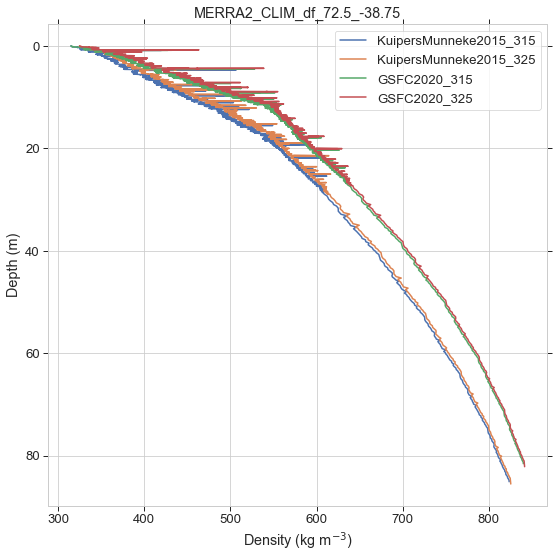

In [15]:
# Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for physics_rv in rd.keys():
    a1.plot(rd[physics_rv]['density'][-1,:],rd[physics_rv]['depth'][-1,:],label=physics_rv)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_Density_Depth.png'
f1.savefig(figfilename)

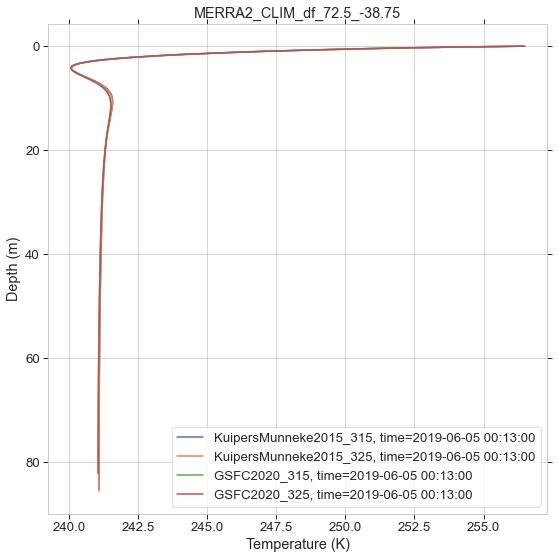

In [16]:
# Plot temperature with depth
f1,a1=plt.subplots(figsize=(8,8))
for physics_rv in rd.keys():
    rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])
    itime = np.where(rd['KuipersMunneke2015_315']['Datetime']>='2019-06')[0][0]
    a1.plot(rd[physics_rv]['temperature'][itime,:],rd[physics_rv]['depth'][itime,:],label=f'{physics_rv}, time={rd[physics_rv]["Datetime"][itime]}')
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Temperature (K)')
a1.set_ylabel('Depth (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_Temp_Depth.png'
f1.savefig(figfilename)

In [17]:
## Use FirnCover to plot temperature contour with colorbar


In [18]:
rd[physics_rv]['model_time'][-1]

2020.9973

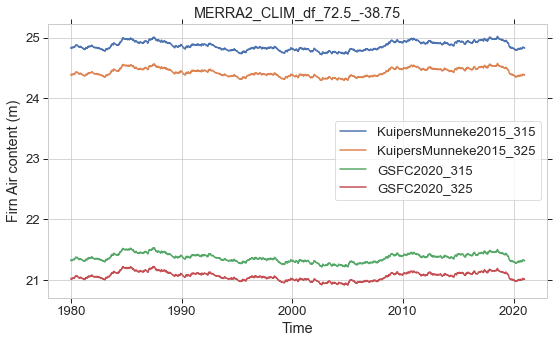

In [19]:
# Plot FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for physics_rv in rd.keys():
    a1.plot(rd[physics_rv]['model_time'][:],rd[physics_rv]['DIP'][:,0],label=physics_rv)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('Firn Air content (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_FAC.png'
f1.savefig(figfilename)

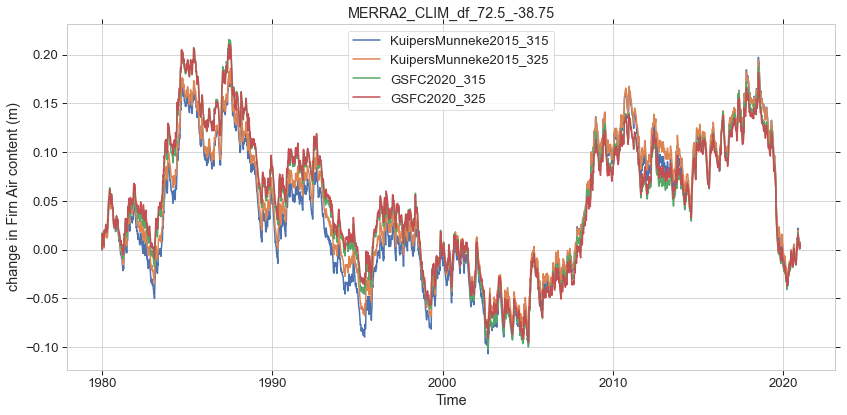

In [20]:
# Plot change in FAC through time
f1,a1=plt.subplots(figsize=(12,6))
for physics_rv in rd.keys():
    a1.plot(rd[physics_rv]['model_time'][:],rd[physics_rv]['DIP'][:,0]-rd[physics_rv]['DIP'][0,0] ,label=physics_rv)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('change in Firn Air content (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_Change_in_FAC.png'
f1.savefig(figfilename)